In [1]:
import pandas
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from super_secret_password import PASSWORD
from matplotlib import pyplot as plt


In [2]:
DATABASE_VALUES= {"url": "jdbc:mysql://localhost:3306/creditcard_capstone",
                "table":["CDW_SAPP_BRANCH", "CDW_SAPP_CREDIT_CARD", "CDW_SAPP_CUSTOMER", "CDW_SAPP_LOAN_APPLICATION"],  # 0 1 2 3
                "mode":"overwrite",
                "properties":{"user":"root", "password":PASSWORD, "driver":"com.mysql.cj.jdbc.Driver"}}

In [3]:
spark_sesh = SparkSession.builder.appName('CLI Spark Session').getOrCreate()

# Importing all for good measure but not required
sql_branch_df = spark_sesh.read.jdbc(
url=DATABASE_VALUES["url"],
properties=DATABASE_VALUES["properties"],
table=DATABASE_VALUES["table"][0]
)

sql_credit_df = spark_sesh.read.jdbc(
    url=DATABASE_VALUES["url"],
    properties=DATABASE_VALUES["properties"],
    table=DATABASE_VALUES["table"][1]
)

sql_customer_df = spark_sesh.read.jdbc(
url=DATABASE_VALUES["url"],
properties=DATABASE_VALUES["properties"],
table=DATABASE_VALUES["table"][2]
)

sql_loan_df = spark_sesh.read.jdbc(
url=DATABASE_VALUES["url"],
properties=DATABASE_VALUES["properties"],
table=DATABASE_VALUES["table"][3]
)

In [52]:
sql_credit_df.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: date (nullable = true)



In [4]:
trans_types_values_df = sql_credit_df[['TRANSACTION_TYPE', 'TRANSACTION_ID', 'TRANSACTION_VALUE', 'CUST_SSN']]

In [54]:
trans_types_values_df.show(5)

+----------------+--------------+-----------------+---------+
|TRANSACTION_TYPE|TRANSACTION_ID|TRANSACTION_VALUE| CUST_SSN|
+----------------+--------------+-----------------+---------+
|         Grocery|         15771|             13.9|123457068|
|           Bills|         15772|             3.23|123457068|
|         Grocery|         15773|            38.33|123457068|
|           Bills|         15774|            29.99|123457068|
|         Grocery|         15775|            87.64|123457068|
+----------------+--------------+-----------------+---------+
only showing top 5 rows



### Transactions Ranked by Type

In [55]:
trans_types_values_df = trans_types_values_df.groupBy('TRANSACTION_TYPE').count().sort(desc('count')) # only 7 choices
# this is verbose af but It's good to get used to pyspark
trans_types_values_df.show()

+----------------+-----+
|TRANSACTION_TYPE|count|
+----------------+-----+
|           Bills| 6861|
|      Healthcare| 6723|
|            Test| 6683|
|       Education| 6638|
|   Entertainment| 6635|
|             Gas| 6605|
|         Grocery| 6549|
+----------------+-----+



In [59]:
to_pd = trans_types_values_df.toPandas()

Text(0.5, 1.0, 'Number of Transactions by Type')

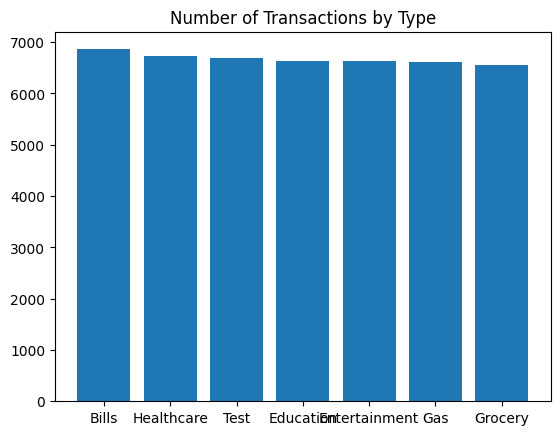

In [68]:
plt.bar(to_pd['TRANSACTION_TYPE'],to_pd['count'])  # only superficial graphs for now
plt.title('Number of Transactions by Type') # NOTE fix this


In [100]:
trans_types_values_sorted = spark_sesh.createDataFrame(trans_types_values_df.groupBy('TRANSACTION_TYPE').count().sort(desc('count')).collect())  

In [101]:
trans_types_values_sorted.show()

+----------------+-----+
|TRANSACTION_TYPE|count|
+----------------+-----+
|           Bills| 6861|
|      Healthcare| 6723|
|            Test| 6683|
|       Education| 6638|
|   Entertainment| 6635|
|             Gas| 6605|
|         Grocery| 6549|
+----------------+-----+



### Transactions Ranked by State

In [5]:
sql_customer_df.printSchema()

root
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: long (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)



In [6]:
trans_state_cust = sql_customer_df[['FIRST_NAME', 'LAST_NAME', 'SSN', 'CUST_STATE']]

In [7]:
customer_state_transaction_df = trans_types_values_df.join(trans_state_cust, trans_state_cust['SSN'] == trans_types_values_df['CUST_SSN'])

In [8]:
customer_state_transaction_df = customer_state_transaction_df.drop('CUST_SSN')

In [9]:
customer_state_transaction_df.printSchema()

root
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)



In [10]:
customer_state_transaction_df.groupBy('CUST_STATE').count().sort(desc('count')).show(40)

+----------+-----+
|CUST_STATE|count|
+----------+-----+
|        NY| 4825|
|        GA| 3772|
|        PA| 3463|
|        FL| 3197|
|        IL| 2961|
|        MI| 2546|
|        MD| 2365|
|        NJ| 2294|
|        CA| 2209|
|        OH| 2018|
|        NC| 1957|
|        VA| 1859|
|        MA| 1746|
|        TX| 1562|
|        WI| 1549|
|        SC| 1358|
|        MN| 1145|
|        MS| 1085|
|        KY|  971|
|        WA|  923|
|        IA|  878|
|        CT|  693|
|        IN|  594|
|        MT|  286|
|        AR|  234|
|        AL|  204|
+----------+-----+



In [11]:
states_transaction_df = spark_sesh.createDataFrame(customer_state_transaction_df.groupBy('CUST_STATE').count().sort(desc('count')).collect())

In [12]:
states_transaction_df.show()

+----------+-----+
|CUST_STATE|count|
+----------+-----+
|        NY| 4825|
|        GA| 3772|
|        PA| 3463|
|        FL| 3197|
|        IL| 2961|
|        MI| 2546|
|        MD| 2365|
|        NJ| 2294|
|        CA| 2209|
|        OH| 2018|
|        NC| 1957|
|        VA| 1859|
|        MA| 1746|
|        TX| 1562|
|        WI| 1549|
|        SC| 1358|
|        MN| 1145|
|        MS| 1085|
|        KY|  971|
|        WA|  923|
+----------+-----+
only showing top 20 rows



In [13]:
to_pd = states_transaction_df.toPandas()

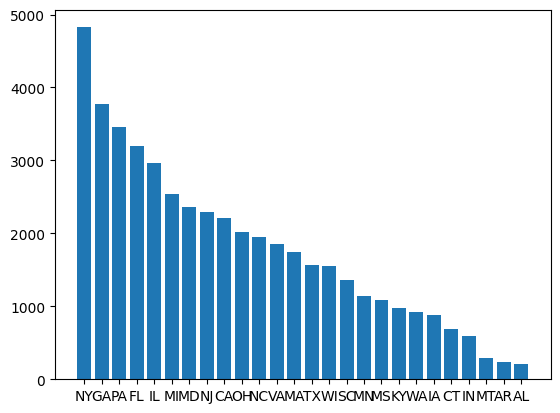

In [17]:
plt.bar(to_pd['CUST_STATE'], to_pd['count'])
plt.show()

### Transactions Ranked by Customer

In [18]:
customer_state_transaction_df.printSchema()

root
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)



In [19]:
transactions_per_customer = spark_sesh.createDataFrame(customer_state_transaction_df.groupBy(['FIRST_NAME', 'LAST_NAME']).count().sort(desc('count')).collect())
# create dataframe iterating through all info from .collect(), otherwise just showing partial data

In [20]:
transactions_per_customer.show()

+----------+---------+-----+
|FIRST_NAME|LAST_NAME|count|
+----------+---------+-----+
|    Lorrie|Whitfield|   99|
|   Brianna|     Ames|   99|
|      Bret|  Perkins|   99|
|   Thurman|     Vera|   99|
|   Chelsea|   Koenig|   99|
|    Carrol|    Lynch|   99|
|    Joesph|  Mcclain|   98|
|     Addie| Cisneros|   98|
|Marguerite| Holloway|   98|
|     Mayra|   Meyers|   98|
|       Rod| Lockhart|   98|
|    Marsha|     Hunt|   98|
|     Adele|    Arias|   98|
|    Virgil|  Mueller|   98|
|       Bud|    Boyce|   98|
|   Whitney|    Boggs|   98|
|    Deanne|Jorgensen|   98|
|     Julie|  Griffin|   97|
|     Staci|    Lilly|   97|
|    Damion|  Kennedy|   97|
+----------+---------+-----+
only showing top 20 rows



In [21]:
to_pd = transactions_per_customer.toPandas()  # have to concat df

### Applications Approved for Self Employed Applicants - Ratio of Approved vs Disapproved

In [113]:
sql_loan_df.printSchema()

root
 |-- Application_ID: string (nullable = true)
 |-- Application_Status: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Self_Employed: string (nullable = true)



In [114]:
sql_loan_df.show(2)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001155|                 Y|             1|         0|Not Graduate|Female|   low|    Yes|    Semiurban|           No|
|      LP001673|                 N|             1|         0|    Graduate|  Male|  high|     No|        Urban|          Yes|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
only showing top 2 rows



In [126]:
applications_self_employed_approved_df = sql_loan_df.filter(sql_loan_df['Application_Status'] == 'Y').filter(sql_loan_df['Self_Employed'] == 'Yes')  # filter does not return NoneType

In [127]:
applications_self_employed_approved_df.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP002626|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001529|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Rural|          Yes|
|      LP002795|                 Y|             1|        3+|    Graduate|  Male|  high|    Yes|    Semiurban|          Yes|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP002813|                 Y|             1|         1|    Graduate|Female|  high|    Yes|    Semiurban|          Yes|


In [128]:
applications_self_employed_denied_df = sql_loan_df.filter(sql_loan_df['Application_Status'] == 'N').filter(sql_loan_df['Self_Employed'] == 'Yes')

In [133]:
applications_self_employed_denied_df.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001673|                 N|             1|         0|    Graduate|  Male|  high|     No|        Urban|          Yes|
|      LP002142|                 N|             0|         0|    Graduate|Female|medium|    Yes|        Rural|          Yes|
|      LP002301|                 N|             1|         0|    Graduate|Female|medium|     No|        Rural|          Yes|
|      LP001186|                 N|             0|         1|    Graduate|Female|  high|    Yes|        Urban|          Yes|
|      LP002318|                 N|             1|         1|Not Graduate|Female|   low|     No|    Semiurban|          Yes|


In [148]:
self_emp_y = len(applications_self_employed_approved_df.collect())  # confirmed in sql # ⭐
self_emp_n = len(applications_self_employed_denied_df.collect())
print(f"""""
======
Self Employed Applicant Loan Status:
------------------------------------ 
Approved: {self_emp_y}
Disapproved: {self_emp_n}
Total: {self_emp_y + self_emp_n}
=====
""")

# ⭐ # collect returns an iterable I can get len of
# prob another way I'm sure but this way works

""
Self Employed Applicant Loan Status:
------------------------------------ 
Approved: 46
Disapproved: 24
Total: 70
=====



In [149]:
ratio_self_emp_y_n = round((self_emp_y / (self_emp_y + self_emp_n)), 2)  # 2 sig figs
print(ratio_self_emp_y_n)

0.66


#### Rejection Rate of Married Male Applicants

In [151]:
sql_loan_df.printSchema()  # need to refresh my memory, don't wanna scroll up or open a side window lol

root
 |-- Application_ID: string (nullable = true)
 |-- Application_Status: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Self_Employed: string (nullable = true)



In [152]:
sql_loan_df.show(1)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001155|                 Y|             1|         0|Not Graduate|Female|   low|    Yes|    Semiurban|           No|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
only showing top 1 row



In [153]:
print(type(sql_loan_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [157]:
from pyspark.sql import DataFrame

In [167]:
sql_loan_df.filter(sql_loan_df['Married'] == 'Yes').filter(sql_loan_df['Gender'] == 'Male')

DataFrame[Application_ID: string, Application_Status: string, Credit_History: bigint, Dependents: string, Education: string, Gender: string, Income: string, Married: string, Property_Area: string, Self_Employed: string]

In [196]:
# need gender == 'Male'
# need application_status == 'Y'
# need married = 'Y'


# ===============
# WARNING - Over Engineered Solution Incoming:
# ===============


# getting fancy with the types
def find_ratio(dataframe : DataFrame, column_dict: dict):  # hardcode married / gender  # app :[y, n]
    return_dict = {}
    return_df = {}
    compiled_results = {}
    df_total = dataframe.filter(dataframe['Married'] == 'Yes').filter(dataframe['Gender'] == 'Male')
    df_total_count = len(df_total.collect())
    return_dict['Total'] = df_total_count
    for column in column_dict.keys():
        for values in column_dict[column]:  # y, n
            df_partial = df_total.filter(df_total[column] == values)
            #print(df_partial.show(1), "\n")
            key = f"{column}: {values}"
            return_dict[key] = len(df_partial.collect())
            return_df[key] = df_partial
            compiled_results['Values'] = return_dict
            compiled_results['DataFrames'] = return_df
    print(compiled_results['Values'])
    return compiled_results

# this was not nessisary at all but it was fun lol
# I'm prob gonna flesh this out at a later time to make it more useful



In [187]:
find_ratio = find_ratio(sql_loan_df, {'Application_Status':['Y', 'N']})


{'Total': 306, 'Application_Status: Y': 219, 'Application_Status: N': 87}


In [195]:
print(find_ratio['Values']['Application_Status: Y'])
print("")
print(find_ratio['Values']['Application_Status: N'])

ratio_married_yes_no = round(find_ratio['Values']['Application_Status: Y'] / find_ratio['Values']['Total'], 3)
ratio_married_yes_no  # 3 sig figs

219

87


0.716

### Top Three Months with Largest Transaction Data


In [214]:
sql_credit_df.printSchema()


root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: date (nullable = true)



In [294]:
month_df = sql_credit_df.to_pandas_on_spark()

c:\Users\GzuzC\OneDrive\Documents\Notes\Personal Studies\Workbooks and Worksheets\Python\PerScholas Data Engineering\perscholas_capstone_project\ignore\ETL-capstone-env\lib\site-packages\pyspark\sql\dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [304]:
sql_credit_month = sql_credit_df

In [307]:
sql_credit_month = sql_credit_df.toPandas()  # need to do this in raw pandas b/c pandas_api and pyspark are crashing no matter what I do 😡

In [308]:
month = sql_credit_month['TIMEID']

In [311]:
month = month.apply(lambda x: str(x).split("-")[1])

In [312]:
sql_credit_month['MONTH'] = month
sql_credit_month

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID,MONTH
0,100,4210653388557910,123457068,15771,Grocery,13.90,2018-12-23,12
1,49,4210653388557910,123457068,15772,Bills,3.23,2018-11-24,11
2,170,4210653388557910,123457068,15773,Grocery,38.33,2018-02-01,02
3,175,4210653388557910,123457068,15774,Bills,29.99,2018-10-09,10
4,93,4210653388557910,123457068,15775,Grocery,87.64,2018-02-01,02
...,...,...,...,...,...,...,...,...
46689,119,4210653381566399,123458197,9076,Bills,2.54,2018-04-20,04
46690,38,4210653381566399,123458197,9077,Education,73.41,2018-07-09,07
46691,10,4210653381566399,123458197,9078,Test,66.87,2018-01-13,01
46692,125,4210653381566399,123458197,9079,Test,94.91,2018-07-22,07


In [334]:
grouped = sql_credit_month.groupby(by="MONTH").count()
grouped_df = grouped[['BRANCH_CODE']]
grouped_df.columns = ['Number of Transactions'.upper()]
grouped_df = grouped_df.sort_values(by='Number of Transactions'.upper(), ascending=False) 
grouped_df

,NUMBER OF TRANSACTIONS
MONTH,
02,3959
05,3946
10,3946
12,3936
07,3935
11,3901
09,3886
08,3861
03,3851


### Which Branch Processed Highest Total Healthcare Transactions

In [5]:
sql_branch_df_join = sql_branch_df.withColumnRenamed('BRANCH_CODE', 'BRANCH_CODE_')  # overcome duplicate columns

In [6]:
branch_transactions_df = sql_branch_df_join.join(sql_credit_df, sql_branch_df_join['BRANCH_CODE_'] == sql_credit_df['BRANCH_CODE'])


In [7]:
branch_transactions_df.printSchema()

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE_: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: date (nullable = true)



In [8]:
branch_transactions_df = branch_transactions_df.drop('BRANCH_CODE_')


In [9]:
branch_transactions_df.printSchema()

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: date (nullable = true)



In [10]:
branch_transactions_pd_df = branch_transactions_df.toPandas()  # again, have to go to pandas b/c insaine crashing w/ pyspark, need to bugfix later

In [33]:
heathcare_pd_df = branch_transactions_pd_df[branch_transactions_pd_df['TRANSACTION_TYPE'] == 'Healthcare']
heathcare_pd_df.head(5)

,BRANCH_CITY,BRANCH_NAME,BRANCH_PHONE,BRANCH_STATE,BRANCH_STREET,BRANCH_ZIP,LAST_UPDATED,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID
4,Glendora,Example Bank,1234785605,CA,School Street,91740,2018-04-18T16:51:47.000-04:00,29,4210653374816736,123457037,15924,Healthcare,30.29,2018-07-20
8,LakeJackson,Example Bank,1234356462,TX,Chestnut Avenue,77566,2018-04-18T16:51:47.000-04:00,26,4210653356896070,123456963,16180,Healthcare,95.07,2018-03-04
12,Glendora,Example Bank,1234785605,CA,School Street,91740,2018-04-18T16:51:47.000-04:00,29,4210653383785923,123456919,16330,Healthcare,59.63,2018-10-06
37,Glendora,Example Bank,1234785605,CA,School Street,91740,2018-04-18T16:51:47.000-04:00,29,4210653368689760,123456629,17866,Healthcare,78.65,2018-10-11
38,LakeJackson,Example Bank,1234356462,TX,Chestnut Avenue,77566,2018-04-18T16:51:47.000-04:00,26,4210653368689760,123456629,17882,Healthcare,35.46,2018-04-09


In [43]:
healthcare_sum = heathcare_pd_df[['TRANSACTION_VALUE', 'BRANCH_CODE']].groupby('BRANCH_CODE').sum().sort_values('TRANSACTION_VALUE', ascending=False)
healthcare_sum = healthcare_sum.reset_index()

In [44]:
healthcare_sum  # TBH this is making me appreciate SQL more and more 

,BRANCH_CODE,TRANSACTION_VALUE
0,25,4370.18
1,60,4072.04
2,83,4003.37
3,36,3823.87
4,111,3720.27
...,...,...
109,160,1983.04
110,74,1965.88
111,192,1960.35
112,15,1873.71
